In [1]:
from skfem import *
from skfem.experimental.autodiff import *
from skfem.experimental.autodiff.helpers import *
from skfem.supermeshing import intersect, elementwise_quadrature
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from jax import device_get
from datetime import datetime
from scipy.sparse.linalg import norm
import os

In [2]:
import numpy as np

def focused_linspace(ymin, ymax, n_element, focus='center', sharpness=5.0):
    """
    집중 분포된 linspace 생성기.
    
    Parameters
    ----------
    ymin, ymax : float
        구간 경계
    n_element : int
        총 분할 수
    focus : str ['center', 'ymin', 'ymax', 'edge']
        집중할 위치 ('edge'는 양 끝)
    sharpness : float
        집중 정도 (클수록 더 집중됨)

    Returns
    -------
    y : np.ndarray
        위치 배열 (n_element 개)
    """
    u = np.linspace(-1, 1, n_element)

    if focus == 'center':
        w = 0.5 * (1 + np.tanh(sharpness * u) / np.tanh(sharpness))
    elif focus == 'ymin':
        w = (np.exp(sharpness * u) - 1) / (np.exp(sharpness) - 1)
    elif focus == 'ymax':
        w = (np.exp(sharpness * (u + 1)) - 1) / (np.exp(sharpness * 2) - 1)
    elif focus == 'edge':
        # 가운데 느슨하게, 양쪽 촘촘하게
        w = 0.5 * (1 - np.tanh(sharpness * u) / np.tanh(sharpness))
    else:
        raise ValueError("focus must be one of: 'center', 'ymin', 'ymax', 'edge'")

    return ymin + w * (ymax - ymin)


In [3]:
from scipy.interpolate import interp1d
import numpy as np
from scipy.interpolate import interp1d

def moving_average_x(xs, values, window_x):
    """
    x 좌표 기준으로 이동평균 수행
    """
    averaged = np.zeros_like(values)
    for i, xi in enumerate(xs):
        mask = np.abs(xs - xi) <= window_x / 2
        if np.any(mask):
            averaged[i] = np.mean(values[mask])
        else:
            averaged[i] = values[i]  # fallback
    return averaged

def curvature_based_resample(xs, ys, n_points = 100, baseline_weight=1.0, eps=1e-10, window_x = 5):
    """
    곡률 기반으로 xs를 재분포하되, 곡률이 0일 때도 기본 밀도 유지.

    Parameters
    ----------
    xs : np.ndarray
        원래 x 좌표
    ys : np.ndarray
        대응하는 y 값
    n_points : int
        재분포할 점 수
    baseline_weight : float
        곡률이 0일 때 기본으로 주는 weight 비율 (기본값=1.0, 즉 곡률 없는 영역도 분할함)
    eps : float
        0 나눔 방지용 소수

    Returns
    -------
    xs_refined : np.ndarray
        곡률 기반으로 재분포된 x좌표
    """
    
    
    # 1차 및 2차 미분
    dy = np.gradient(ys, xs)
    d2y = np.gradient(dy, xs)

    # 곡률 기반 weight + 기본 weight 혼합
    curvature_weight = moving_average_x(xs, np.abs(d2y), window_x)
    weight = curvature_weight + baseline_weight + eps  # baseline 유지
    weight /= np.sum(weight)  # 정규화

    # 누적 분포 함수
    cdf = np.cumsum(weight)
    

    
    cdf = (cdf - cdf[0]) / (cdf[-1] - cdf[0])  # normalize to [0, 1]


    #좌우 대칭
    if len(cdf) % 2 == 0:
        cdf[len(cdf)//2:] = 1 - cdf[:len(cdf)//2][::-1]
    else:
        cdf[len(cdf)//2+1:] = 1 - cdf[:len(cdf)//2][::-1]
        cdf[len(cdf)//2] = 0.5

    # 역보간으로 새 xs 생성
    inv_cdf = interp1d(cdf, xs, kind='linear', fill_value='extrapolate')
    xs_refined = inv_cdf(np.linspace(0, 1, n_points))
    

    return xs_refined



In [151]:
def cp(E, h, topo, wavelength):
    d_mean =  topo
    k_mean = topo**2 * (2*np.pi)**4 / wavelength **4 * 1/2
    I = 1/12 * h**3
    return 0.5 * E * I * k_mean / d_mean 

def critical_topo(E, h, wavelength, Pmin):
    D = 0.5 * E * 1/12 * h**3
    k = 2*np.pi / wavelength
    return 2 * Pmin / (D * k**4) * 2

def critical_topo2(E, h, wavelength, gamma):
    D = 0.5 * E * 1/12 * h**3
    k = 2*np.pi / wavelength
    kapa_max = np.sqrt(gamma / D)
    
    return kapa_max / k**2 * 2

In [140]:
np.sqrt(2 * 0.5 / 130e9 / 1.64e-15) * 100e-6 / np.pi**2 

0.0006939156054452902

In [141]:
690 / 16

43.125

In [ ]:
69

In [132]:
1/12 * 27e-6**3

1.6402499999999998e-15

In [96]:

cp(130e9, 27e-6, 16*3e-9/2 ,2*100e-6)

1246247.040234475

In [162]:
critical_topo2(130e9, 27e-6, 2 * 100e-6, 0.5)

1.3877254431648704e-07

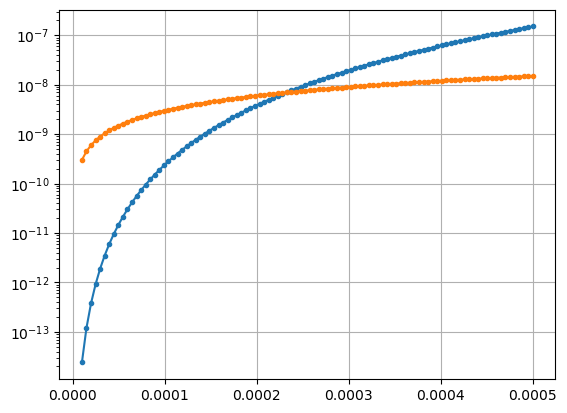

In [161]:
ls = np.linspace(10e-6, 500e-6, 100)
plt.plot(ls, critical_topo(130e9, 27e-6, 2 * ls, 1e5) / 16, '.-')
plt.plot(ls, ls * (3e-9 / 100e-6), '.-')
plt.semilogy()
plt.grid()


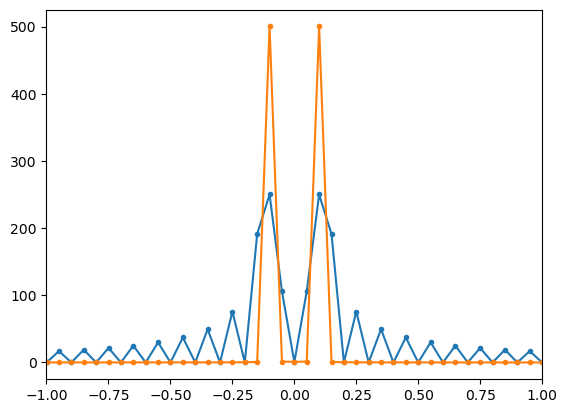

In [108]:
import numpy as np

xs = np.linspace(-10, 10, 1000)
ys = np.cos(np.pi * xs /5)
ys[xs > 5] = 0
ys[xs < -5] = 0
fft =np.fft.fft(ys)
fftshift = np.fft.fftshift(fft)
fftfreq = np.fft.fftfreq(len(ys), xs[1]-xs[0])
fftfreqshift = np.fft.fftshift(fftfreq)
plt.plot(fftfreqshift, np.abs(fftshift), '.-')

ys = np.cos(np.pi * xs /5)
fft =np.fft.fft(ys)
fftshift = np.fft.fftshift(fft)
fftfreq = np.fft.fftfreq(len(ys), xs[1]-xs[0])
fftfreqshift = np.fft.fftshift(fftfreq)
plt.plot(fftfreqshift, np.abs(fftshift), '.-')

plt.xlim(-1,1)
plt.show()


In [ ]:
def cp(E, h, topo, wavelength):
    return np.pi**4 * topo * E * h**3 / (3 * wavelength**4)


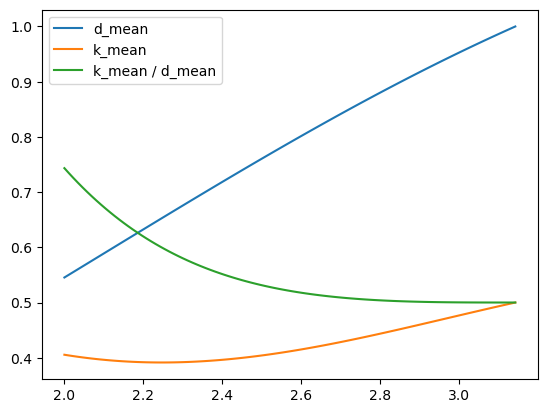

In [59]:
def d_mean(x):
    x_cut = np.clip(x, 0.001, np.inf)
    return (x - np.sin(x)) / x

def k_mean(x):
    return (x/2 + np.sin(2*x)/4) / x

xs = np.linspace(2, np.pi, 100)
plt.plot(xs, 1 - np.sin, label = 'd_mean')
plt.plot(xs, k_mean(xs), label = 'k_mean')
plt.plot(xs, k_mean(xs) / d_mean(xs), label = 'k_mean / d_mean')
plt.legend()
plt.show()


<Axes: >

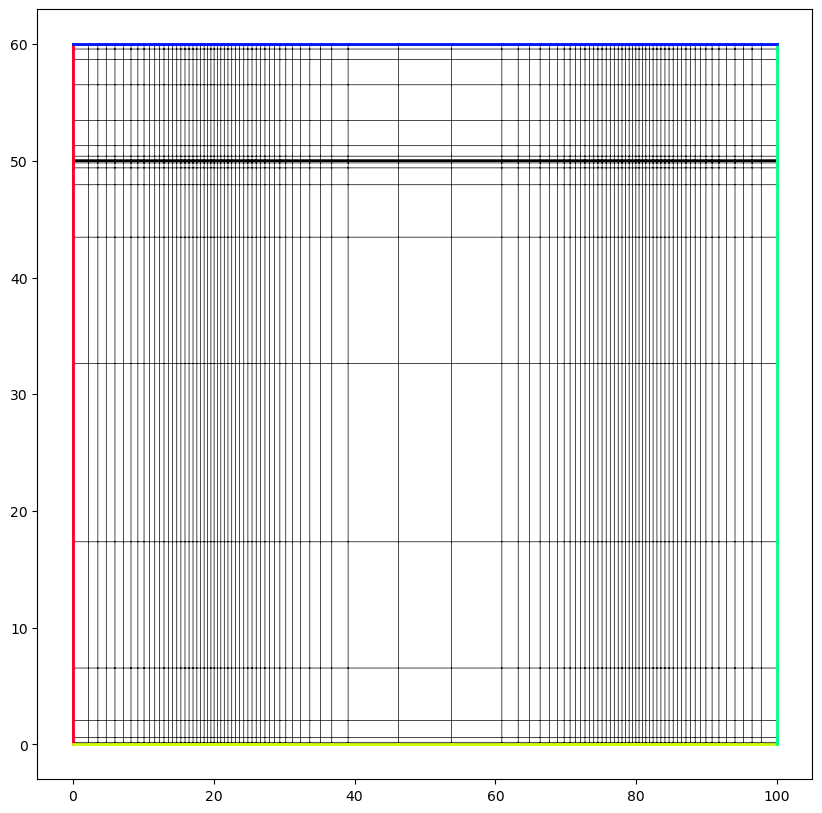

In [4]:
from skfem import *



def create_alpine(xs, center_x, amplitude, half_width):
    mask = np.ones_like(xs)
    ys = amplitude/2 + amplitude/2 * np.cos((xs - center_x) * np.pi / half_width )
    mask[xs > (center_x + half_width)] = 0
    mask[xs < (center_x - half_width)] = 0
    ys = ys * mask
    return ys


def deform_top_surface(mesh, top_deformations, ny, direction = 'top'):
    """Deform the mesh while preserving vertical ordering and fixing the bottom surface
    
    Args:
        mesh: The mesh to deform
        top_deformations: Array of target deformations for each point on the top surface
        amplitude: Maximum deformation amplitude
    """
    n_layers = ny

    
    # Apply deformation to all layers except the bottom
    for i in range(n_layers):  # Exclude the bottom layer
        # Find nodes in this layer
        layer_nodes = np.arange(i, len(mesh.p[0]), ny)
        # Calculate deformation for this layer
        # Amplitude decreases linearly from top to bottom
        # The bottom layer (i = n_layers-2) will have zero deformation
        if direction == 'top':
            layer_amplitude = i / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        else:
            layer_amplitude = (n_layers - i) / (n_layers - 1)  # Adjusted for bottom layer exclusion
            deformation = top_deformations * layer_amplitude
        
        # Apply deformation
        mesh.p[1, layer_nodes] += deformation
        
def merge_array(arr1, arr2):
    return np.sort(np.unique(np.concatenate([arr1, arr2])))

    
xs = np.linspace(0,100,1000)
ys = create_alpine(xs, 20, 50, 10) + create_alpine(xs, 80, 50, 10) 
xs_refined = curvature_based_resample(xs=xs, ys=ys, baseline_weight=0.1, n_points=100, window_x = 20)
ys_refined = interp1d(xs, ys, kind='cubic', fill_value='extrapolate')(xs_refined)


ny = 20

ys_si = focused_linspace(0, 50, ny, focus = 'edge', sharpness=6)
ys_sio2 = focused_linspace(0, 10, ny, focus = 'edge', sharpness=6) + 50

ys = merge_array(ys_si, ys_sio2)

m1 = MeshQuad.init_tensor(xs_refined, ys).with_defaults()
#deform_top_surface(m1, ys_refined, len(ys), direction = 'top')

fig,ax=  plt.subplots(figsize=(10,10))
m1.draw(ax = ax, boundaries=False)

In [ ]:
def create_mesh_with_topo(topo_width, topo_height, topo_center, chip_thk, chip_width, nx, ny):
    xs_topo = np.linspace(-topo_width*5, topo_width*5, nx)
    xs = merge_array(xs_topo, np.linspace(-chip_width/2, chip_width/2, nx))
    ys = create_alpine
    return xs

In [24]:
from skfem import *
from skfem.experimental.autodiff import *
from skfem.experimental.autodiff.helpers import *
from skfem.supermeshing import intersect, elementwise_quadrature
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from jax import device_get, device_put
from datetime import datetime
from scipy.sparse.linalg import norm
import os
from IPython.display import clear_output



L0 = 1e-9

width = 1e-2 / L0
sithk = 38e-6 / L0
sio2_thk = 3e-6 / L0
xs = np.linspace(-width/2,width/2,50)


amp = 3e-9  / L0
topo_width = 500e-6 / L0
toop_center = 0 / L0
ys = create_alpine(xs, toop_center, amp, topo_width)
xs_refined = curvature_based_resample(xs=xs, ys=ys, baseline_weight=0.1, n_points=100, window_x = 20)
ys_refined = interp1d(xs, ys, kind='cubic', fill_value='extrapolate')(xs_refined)

ny = 10

ys_si = focused_linspace(0, sithk, 20, focus = 'edge', sharpness=2)
ys_sio2 = focused_linspace(0, sio2_thk, ny, focus = 'edge', sharpness=1) + sithk

ys = merge_array(ys_si, ys_sio2)

m1 = MeshQuad.init_tensor(xs_refined, ys).with_defaults()
deform_top_surface(m1, ys_refined, len(ys), direction = 'top')

fig,ax=  plt.subplots(figsize=(10,10))
m1.draw(ax = ax, boundaries=False)
plt.show()

mid = m1.p[1, m1.t].mean(axis=0)
material_id = np.where(mid <= sithk, 1, 2)  # 임계값 기준

# 요소마다 다른 영률 (예: 두 개의 재질)
E1, E2 = 130e9 * L0**2, 70e9 * L0**2
E_elem = np.where(material_id == 1, E1, E2)

nu1, nu2 = 0.27, 0.17
nu_elem = np.where(material_id == 1, nu1, nu2)
# lame 계수 계산

lam = E_elem * nu_elem / ((1 + nu_elem) * (1 - 2 * nu_elem))
mu  = E_elem / (2 * (1 + nu_elem))

lam = lam.reshape(1,1,len(lam),1)
mu = mu.reshape(1,1,len(mu),1)

basis1 = Basis(m1, ElementVector(ElementQuad1()))
pbasis1 = basis1.with_element(ElementQuad0())

n_elem = m1.t.shape[1]
p0 = 0.21e9 * L0**2
sigma0 = np.zeros((2, 2, n_elem))
sigma0[0, 0, material_id == 2] = p0

x = np.zeros(basis1.N)

@NonlinearForm(hessian=True)
def J1(u, w):
    eps = 0.5 * (grad(u) + transpose(grad(u)) + mul(transpose(grad(u)), grad(u)))
    sig = 2 * mu * eps + lam * eye(trace(eps), 2)

    return 0.5 * ddot(sig - sigma0[:,:,:,np.newaxis], eps)
    
for i in range(1000):
    clear_output(wait = True)
    xres = x
    pbasis1 = basis1.with_element(ElementQuad0())
    u1 = basis1.interpolate(x)
    eps1 = 0.5 * (grad(u1) + transpose(grad(u1)) + mul(transpose(grad(u1)), grad(u1)))
    sig1 = 2 * mu * eps1 + lam * eye(trace(eps1), 2)
    sigma_xx1 = np.array(sig1[1, 0])
    pbasis1_defo = Basis(m1.translated(xres[basis1.nodal_dofs]), ElementQuad0())
    sigma_proj1 = pbasis1.project(u1[0])

    def max_abs(arr):
        return max(abs(np.percentile(arr, 1)), abs(np.percentile(arr, 99)))

    fig, ax = plt.subplots(ncols  =2,  figsize = (16,8))

    pbasis1_defo.plot(sigma_proj1, ax=ax[0], cmap='coolwarm', shading='gouraud', vmin=-max_abs(sigma_proj1), vmax=max_abs(sigma_proj1))
    plt.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', label='$\\sigma_{xx}$ [N/um²]')
    m1.translated(xres[basis1.nodal_dofs]).draw(ax =ax[0])
    
    m1defo  =m1.translated(xres[basis1.nodal_dofs])
    x_top,y_top = m1defo.p[:,m1defo.facets[0, m1defo.boundaries['top']]]
    ax[1].plot(x_top,y_top,'.')
    plt.show()
    
    jac, rhs = J1.assemble(basis1, x = x)
    x_coords = m1.p[0]  # x 좌표 (shape: [n_nodes])
    x_center = (x_coords.min() + x_coords.max()) / 2  # 전체 범위의 중간
    i_mid = np.argmin(np.abs(x_coords - x_center)) 
    dof_x_mid = basis1.get_dofs().flatten()[2 * i_mid : 2* i_mid+2]
    D = np.concatenate([dof_x_mid])

    dx = solve(*enforce(jac, rhs, D=D))
    print(dx.min(), dx.max())
    eta = 1
    x += eta * dx



KeyboardInterrupt: 

In [22]:
ys[::-1]

array([41000.        , 40783.02459889, 40493.97899874, 40133.23635367,
       39717.94306651, 39282.05693349, 38866.76364633, 38506.02100126,
       38216.97540111, 38000.        , 37638.88048711, 37101.46295785,
       36311.02462713, 35168.31278991, 33556.84267865, 31362.13121606,
       28510.76186267, 25024.93250556, 21067.00072322, 16932.99927678,
       12975.06749444,  9489.23813733,  6637.86878394,  4443.15732135,
        2831.68721009,  1688.97537287,   898.53704215,   361.11951289,
           0.        ])

In [17]:
x_coords = m1.p[0]  # x 좌표 (shape: [n_nodes])
x_center = (x_coords.min() + x_coords.max()) / 2  # 전체 범위의 중간
i_mid = np.argmin(np.abs(x_coords - x_center)) 
dof_x_mid = basis1.get_dofs().flatten()[2 * i_mid]

696

In [482]:
u_total = x + u0
u1 = basis1.interpolate(u_total)
eps = 0.5 * (grad(u1) + transpose(grad(u1)))
sig = 2 * mu * eps + lam * eye(trace(eps), 2)
sig_xx = np.array(sig[0, 0])
sig_xx

array([[-896298.82535168, -911823.72196312, -927348.61857457, ...,
        -907874.87854149, -923399.77515293, -938924.67176438],
       [-912054.81499087, -927148.80564736, -942242.79630384, ...,
        -929424.88107813, -944518.87173461, -959612.86239109],
       [-935609.00532297, -950103.53772812, -964598.07013328, ...,
        -961474.06782126, -975968.60022642, -990463.13263158],
       ...,
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        , ...,
              0.        ,       0.        ,       0.        ]])

In [438]:
basis1.interpolate(m1.p.T.flatten())[1]

array([[4.06987705e-02, 4.06987705e-02, 4.06987705e-02, ...,
        3.20420742e-01, 3.20420742e-01, 3.20420742e-01],
       [4.21687363e-01, 4.21687363e-01, 4.21687363e-01, ...,
        8.37969192e-01, 8.37969192e-01, 8.37969192e-01],
       [9.87620758e-01, 9.87620758e-01, 9.87620758e-01, ...,
        1.59989166e+00, 1.59989166e+00, 1.59989166e+00],
       ...,
       [4.01738927e+01, 4.01738927e+01, 4.01738927e+01, ...,
        4.04533227e+01, 4.04533227e+01, 4.04533227e+01],
       [4.05265549e+01, 4.05265549e+01, 4.05265549e+01, ...,
        4.07504487e+01, 4.07504487e+01, 4.07504487e+01],
       [4.08074781e+01, 4.08074781e+01, 4.08074781e+01, ...,
        4.09755465e+01, 4.09755465e+01, 4.09755465e+01]])

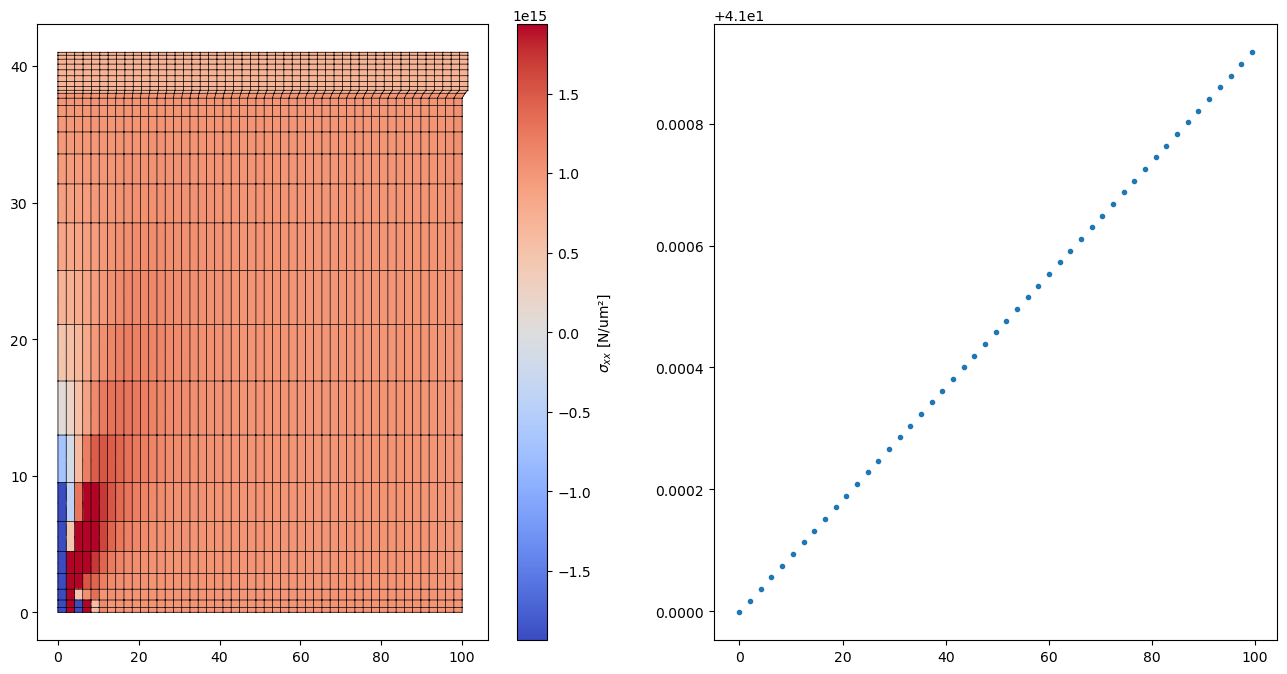

In [414]:
xres = x - u0
pbasis1 = basis1.with_element(ElementQuad0())
u1 = basis1.interpolate(x)
eps1 = 0.5 * (grad(u1) + transpose(grad(u1)) + mul(transpose(grad(u1)), grad(u1)))
sig1 = 2 * mu * eps1 + lam * eye(trace(eps1), 2)
sigma_xx1 = np.array(sig1[1, 1])
pbasis1_defo = Basis(m1.translated(xres[basis1.nodal_dofs]), ElementQuad0())
sigma_proj1 = pbasis1.project(sigma_xx1)

def max_abs(arr):
    return max(abs(np.percentile(arr, 1)), abs(np.percentile(arr, 99)))

fig, ax = plt.subplots(ncols  =2,  figsize = (16,8))

pbasis1_defo.plot(sigma_proj1, ax=ax[0], cmap='coolwarm', shading='gouraud', vmin=-max_abs(sigma_proj1), vmax=max_abs(sigma_proj1))
plt.colorbar(ax[0].collections[0], ax=ax[0], orientation='vertical', label='$\\sigma_{xx}$ [N/um²]')
m1.translated(xres[basis1.nodal_dofs]).draw(ax =ax[0])

m1defo  =m1.translated(xres[basis1.nodal_dofs])
x_top,y_top = m1defo.p[:,m1defo.facets[0, m1defo.boundaries['top']]]
ax[1].plot(x_top,y_top,'.')
plt.show()

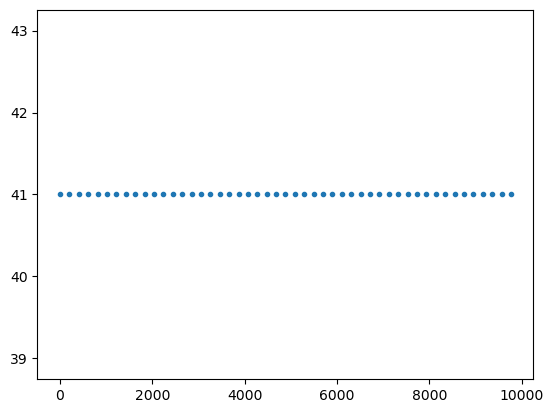

In [401]:
m1defo  =m1.translated(xres[basis1.nodal_dofs])
x,y = m1defo.p[:,m1defo.facets[0, m1defo.boundaries['top']]]
plt.plot(x,y,'.')
plt.show()

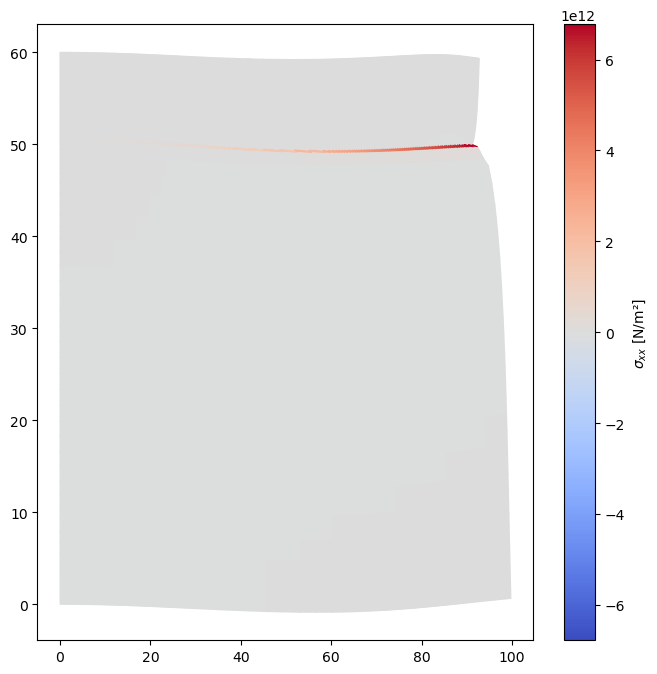

In [361]:
pbasis1 = basis1.with_element(ElementQuad0())
u1 = basis1.interpolate(x)
eps1 = 0.5 * (grad(u1) + transpose(grad(u1)) + mul(transpose(grad(u1)), grad(u1)))
sig1 = 2 * mu * eps1 + lam * eye(trace(eps1), 2)
sigma_xx1 = np.array(sig1[0, 0])
pbasis1_defo = Basis(m1.translated((x-u0)[basis1.nodal_dofs]), ElementQuad0())
sigma_proj1 = pbasis1.project(sigma_xx1)

def max_abs(arr):
    return max(abs(arr.min()), abs(arr.max()))

fig, ax = plt.subplots(figsize = (8,8))

pbasis1_defo.plot(sigma_proj1, ax=ax, cmap='coolwarm', shading='gouraud', vmin=-max_abs(sigma_proj1), vmax=max_abs(sigma_proj1))
plt.colorbar(ax.collections[0], ax=ax, orientation='vertical', label='$\\sigma_{xx}$ [N/m²]')

In [346]:
sig

NameError: name 'sig' is not defined

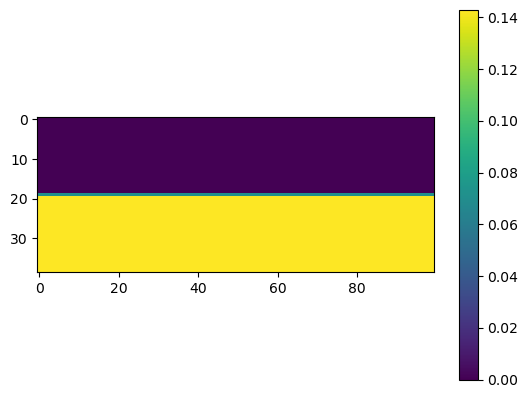

In [326]:

plt.imshow(eps_xx_node.reshape(len(xs_refined), len(ys)).T)
plt.colorbar()
plt.show()


In [335]:
node_material = np.zeros(m1.p.shape[1], dtype=int)
for e in range(m1.t.shape[1]):
    for node in m1.t[:, e]:
        node_material[node] = material_id[e]
compress_mask = (node_material != 1)
compress_mask = compress_mask.reshape(len(xs_refined), len(ys)).T



IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [215]:
from skfem.visuals.matplotlib import plot, draw

# interpolate: (2, npts), 즉 각 점에서의 (fx, fy)
f_vec = basis.interpolate(f_stress)

# 또는 x/y 성분 각각 시각화
plot(basis.mesh, f_vec[0])
plt.title("X-direction force")
plt.colorbar()
plt.show()


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

Error in callback <function _draw_all_if_interactive at 0x0000028467277A60> (for post_execute), with arguments args (),kwargs {}:


ValueError: Collections can only map rank 1 arrays

ValueError: Collections can only map rank 1 arrays

<Figure size 640x480 with 1 Axes>

In [162]:
m1.boundaries

AttributeError: 'NoneType' object has no attribute 'draw'

In [33]:
1e5 / 130e9 * (300 / 40) ** 3

0.00032451923076923077

In [39]:
1e5 * (100e-6)**3 / (75 * 40e-6 ** 3 * 130e9)

1.6025641025641025e-07

In [40]:
1/12 * 

0.00047999999999999996